In [345]:
%matplotlib inline
%precision 16
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
import random
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [346]:
#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    #"^N225",
    #"^RMCC",
    #"^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^IXIC"]

In [347]:
def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df, slope_val, days_val):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

def lump_sum_strategy(df, initial_investment, interval):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)


In [348]:
class ContextualMultiArmedBandit:
    def __init__(self, n_arms, n_features, epsilon=0.1, decay=0.99):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.decay = decay
        self.counts = [0] * n_arms
        self.models = [LogisticRegression(max_iter=1000) for _ in range(n_arms)]
        self.data = [np.zeros((0, n_features)) for _ in range(n_arms)]
        self.targets = [[] for _ in range(n_arms)]
        self.is_fitted = [False] * n_arms  # Track whether each model is fitted

    def select_arm(self, features):
        self.epsilon *= self.decay
        if random.random() < self.epsilon or not any(self.is_fitted):
            arm = random.randint(0, self.n_arms - 1)
            print(f"Randomly chosen arm {arm} due to epsilon or no fitted model.")
        else:
            probabilities = np.array([
                model.predict_proba([features])[0, 1] if self.is_fitted[i] else float('-inf')
                for i, model in enumerate(self.models)
            ])
            arm = np.argmax(probabilities)
            print(f"Exploited arm {arm} based on model predictions.")
        self.counts[arm] += 1
        return arm

    def update(self, chosen_arm, outcome, features):
        self.data[chosen_arm] = np.vstack([self.data[chosen_arm], features])
        self.targets[chosen_arm].append(outcome)
        
        # Fit the model if there are enough diverse data points
        if len(self.targets[chosen_arm]) > 1 and len(set(self.targets[chosen_arm])) > 1:
            self.models[chosen_arm].fit(self.data[chosen_arm], self.targets[chosen_arm])
            self.is_fitted[chosen_arm] = True  # Update the fit status



def generate_features(data, window_size=100):
    min_window = min(window_size, len(data))  # Use smaller windows if not enough data
    if len(data) < min_window:
        return None  # Return None if even the minimum required data is not available

    features = pd.DataFrame(index=data.index)
    features['close'] = data['close']
    # Use available data for moving average and volatility calculations
    features['moving_average'] = data['close'].rolling(window=min_window).mean()
    features['volatility'] = data['close'].rolling(window=min_window).std()
    features['momentum'] = data['close'].pct_change(periods=min(10, len(data)-1))  # Adjust momentum calculation too if needed
    features.dropna(inplace=True)  # Drop rows with NaN values
    return features


def dca_analysis(testing_df, moving_averages_df, initial_investment, time_interval, slope_val, days_val):
    lump_sum_res = lump_sum_strategy(testing_df, initial_investment, time_interval)
    dca_res = dca_strategy(testing_df, initial_investment, time_interval)
    lump_sum_with_delay_res = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_df, slope_val, days_val)

    lump_sum_with_delay_value = lump_sum_with_delay_res["portfolio_value"][-1]
    dca_value = dca_res["portfolio_value"][-1]
    lump_sum_value = lump_sum_res["portfolio_value"][-1]

    return [lump_sum_with_delay_value, dca_value, lump_sum_value,lumpy_date]


def simulate_outcome(strategy_index, df, moving_averages_df, time_interval, initial_investment, slope_val, days_val):
    
    #0 = lump sum delay
    #1 = dca
    #2 = lump sum
    results = dca_analysis(df, moving_averages_df, initial_investment, time_interval, slope_val, days_val)
    print(results)
    print("results: ", results)
    print("max: ", np.argmax(results[:-1]), " strat idx: ", strategy_index)
    if np.argmax(results[:-1])==strategy_index:
        return 1
    else:
        return 0

def test_bandit(test_data, bandit, moving_averages_df):
    # Results storage
    decisions = []
    successes = []

    # Loop through the test dataset
    for date in test_data.index:
        context_data = test_data.loc[:date]  # Get all data up to the current date
        features = generate_features(context_data)
        if features is not None and not features.empty:
            print("shape: ", features.shape, features)
            if features.shape[1] == 4:
                chosen_arm = bandit.select_arm(features.iloc[-1].values)  # Use the latest available features
                print("Chosen arm: ", chosen_arm)
                outcome = simulate_outcome(chosen_arm, context_data, moving_averages_df, time_interval, initial_investment, slope_val, days_val)
                decisions.append(chosen_arm)
                successes.append(outcome)  # Adjust based on what outcome actually returns
            else:
                print(f"Skipping date {date}: feature vector size mismatch")
                continue  # Skip this loop iteration if features are not available or mismatched
        else:
            continue  # Skip if features are not available

    # Calculate performance metrics
    accuracy = np.mean(successes)
    print(f"Accuracy of the bandit during testing: {accuracy:.2f}")

    return decisions, successes

In [349]:
def plot_cumulative_rewards(decisions, rewards):
    # Calculate cumulative rewards for each strategy
    cumulative_rewards = {i: [] for i in range(3)}  # Assuming three strategies
    for arm in range(3):
        arm_rewards = [reward for decision, reward in zip(decisions, rewards) if decision == arm]
        cumulative_rewards[arm] = np.cumsum(arm_rewards)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for arm, cum_rewards in cumulative_rewards.items():
        plt.plot(cum_rewards, label=f'Strategy {arm}')
    
    plt.title('Cumulative Rewards by Strategy')
    plt.xlabel('Number of Decisions')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

In [350]:
# Define parameters
moving_average = 200
time_interval = 21
training_start_date = '2010-12-31'
training_end_date = '2017-12-31'
testing_start_date = '2018-01-01'
testing_end_date = '2024-12-01'
train_years = 7
test_years = 6
moving_average_window = 100
max_val = 10
 

# Split the dataset into in-sample (training) and out-of-sample (testing)
training_df = sandp_time[training_start_date:training_end_date]
testing_df = sandp_time[testing_start_date:testing_end_date]

# Fit the curve on the training dataset
def exponential_func(x, a, b):
    return a * np.exp(b * x)

x_values_train = np.arange(len(training_df))
y_values_train = training_df['close']
initial_guess = (1.0, 0.001)
popt, pcov = curve_fit(exponential_func, x_values_train, y_values_train, p0=initial_guess)
trendline_train = exponential_func(x_values_train, *popt)

# Apply the trendline to the testing dataset
x_values_test = np.arange(len(testing_df)) + len(training_df)
trendline_test = exponential_func(x_values_test, *popt)
testing_df['Trendline'] = trendline_test

# Calculate moving averages for the testing dataset
moving_averages_test = pd.DataFrame()
full_set = sandp_time[training_start_date:testing_end_date]
moving_averages_test = full_set['close'].rolling(window=moving_average_window).mean()[len(full_set)-len(testing_df):]

moving_averages_train = pd.DataFrame()
moving_averages_train = full_set['close'].rolling(window=moving_average_window).mean()[len(full_set)-len(training_df):]


In [351]:
features_df

,close,moving_average,volatility,momentum
2015-08-14,5048.240234,5039.273989,78.573674,-0.015607
2015-08-17,5091.700195,5041.425791,77.002232,-0.004629
2015-08-18,5059.350098,5043.385693,74.889462,-0.009049
2015-08-19,5019.049805,5044.663989,73.340854,-0.023520
2015-08-20,4877.490234,5043.964492,74.600270,-0.035390
2015-08-21,4706.040039,5042.016094,80.672360,-0.066917
2015-08-24,4526.250000,5038.476294,94.435154,-0.112813
2015-08-25,4506.490234,5034.671797,107.378323,-0.105285
2015-08-26,4697.540039,5032.473999,111.956143,-0.068760
2015-08-27,4812.709961,5031.498799,113.446519,-0.043876


In [352]:
moving_averages_test

2018-01-02     6619.845781
2018-01-03     6628.332378
2018-01-04     6636.545879
2018-01-05     6644.509180
2018-01-08     6652.752983
                  ...     
2024-04-29    15577.938984
2024-04-30    15592.218086
2024-05-01    15606.805791
2024-05-02    15621.815488
2024-05-03    15639.339072
Name: close, Length: 1595, dtype: float64

In [353]:
start_dates[0], end_dates[0]

(numpy.datetime64('2015-08-14T00:00:00.000000000'),
 Timestamp('2015-09-04 00:00:00'))

In [354]:
moving_averages_test[start_dates[0]:end_dates[0]]

Series([], Name: close, dtype: float64)

In [355]:
# Parameters
moving_average_window = 100
time_interval = 21
initial_investment = 10000
show_graph = False
slope_val = 0.001
days_val = 6

# Example usage within a training loop
mab = ContextualMultiArmedBandit(3, 4)

start_dates = training_df.loc[training_start_date:training_end_date].index

start_dates = np.random.choice(training_df.loc[training_start_date:training_end_date].index, size = 100)
end_dates = [date + pd.DateOffset(days=time_interval) for date in start_dates]
print(len(start_dates), len(end_dates))


for round in range(100):  # Number of training iterations
    print(" --- ROUND ", round)
    
    features_df = generate_features(training_df)[start_dates[round]:end_dates[round]]
    print("Featurs df: ", features_df)
    
    if features_df is not None and not features_df.empty:
        # Get the last row as a single feature vector
        print("df: ", features_df.shape)
        features_vector = features_df.values[:-1]  # Reshape for compatibility with sklearn
        print("vec:", features_vector.shape)
        chosen_arm = mab.select_arm(features_vector)
        print("chosen arm: ", chosen_arm)
        outcome = simulate_outcome(chosen_arm, features_df, moving_averages_train[start_dates[round]:end_dates[round]], time_interval, initial_investment, slope_val, days_val)
        mab.update(chosen_arm, outcome, features_vector)
    else:
        print(features_df)
        print("Insufficient data for generating features.")
print("Completed Training")




100 100
 --- ROUND  0
Featurs df:                    close  moving_average  volatility  momentum
2013-09-27  3781.590088     3564.609407  121.908870  0.015961
2013-09-30  3771.479980     3568.191506  122.677378  0.014425
2013-10-01  3817.979980     3572.279607  124.127635  0.019297
2013-10-02  3815.020020     3576.064006  125.707521  0.008294
2013-10-03  3774.340088     3579.419507  126.482283 -0.003969
2013-10-04  3807.750000     3582.870906  127.962991  0.008748
2013-10-07  3770.379883     3585.858503  128.824071  0.001352
2013-10-08  3694.830078     3588.154404  128.698510 -0.019484
2013-10-09  3677.780029     3589.942505  128.689059 -0.022153
2013-10-10  3760.750000     3592.585706  129.461139 -0.007044
2013-10-11  3791.870117     3595.483206  130.652951  0.002718
2013-10-14  3815.280029     3599.003005  131.792173  0.011613
2013-10-15  3794.010010     3602.348906  132.458238 -0.006278
2013-10-16  3839.429932     3606.151807  133.757873  0.006398
2013-10-17  3863.149902     3609.89

IndexError: single positional indexer is out-of-bounds

shape:  (1, 4)                   close  moving_average  volatility  momentum
2018-01-03  7065.529785     7036.214844   41.457588  0.008367
Randomly chosen arm 1 due to epsilon or no fitted model.
Chosen arm:  1
[0.0, 10000.0, 0.0, Timestamp('2018-01-02 00:00:00')]
results:  [0.0, 10000.0, 0.0, Timestamp('2018-01-02 00:00:00')]
max:  1  strat idx:  1
shape:  (1, 4)                   close  moving_average  volatility  momentum
2018-01-04  7077.910156     7050.113281    37.93238  0.010134
Randomly chosen arm 0 due to epsilon or no fitted model.
Chosen arm:  0
[0.0, 10000.0, 0.0, Timestamp('2018-01-02 00:00:00')]
results:  [0.0, 10000.0, 0.0, Timestamp('2018-01-02 00:00:00')]
max:  1  strat idx:  0
shape:  (1, 4)                   close  moving_average  volatility  momentum
2018-01-05  7136.560059     7071.724976   53.174289  0.018505
Randomly chosen arm 2 due to epsilon or no fitted model.
Chosen arm:  2
[0.0, 10000.0, 0.0, Timestamp('2018-01-02 00:00:00')]
results:  [0.0, 10000.0, 0.0, T

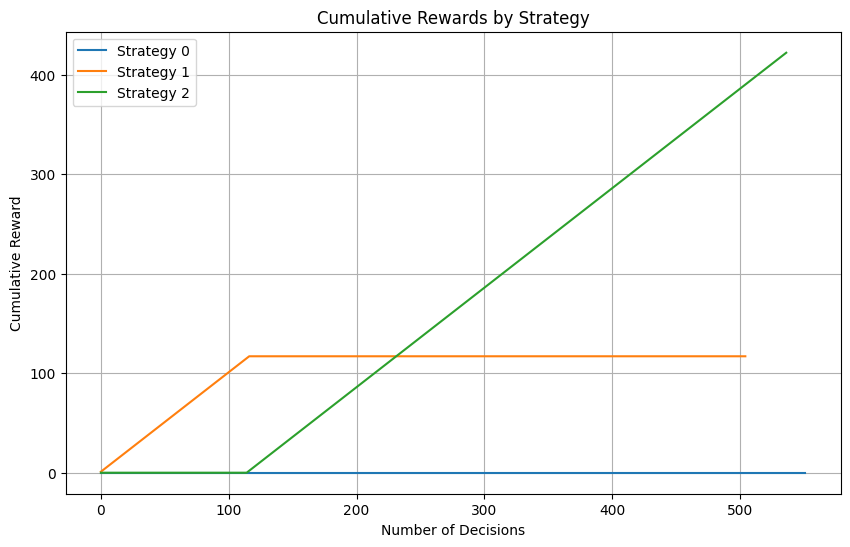

In [ ]:
# Assume 'test_data' is your DataFrame containing the testing data
# Assume 'mab' is your already trained ContextualMultiArmedBandit instance
decisions, successes = test_bandit(testing_df, mab, moving_averages_test)

# Example usage
# decisions = [result from testing]
# rewards = [1 if success else 0 from testing outcomes]
plot_cumulative_rewards(decisions, successes)